# Task 2: Clustering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [2]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,Monetary,Recency,T,Frequency
CustomerID,,,,,,,
12747.0,6.674561,3.367296,4.941642,5.762366,2.079442,5.831882,5.467828
12748.0,9.485925,7.273786,7.108244,5.814429,4.553877,5.828946,5.230059
12749.0,7.110696,4.787492,6.439350,5.746523,1.098612,5.817111,6.259486
12820.0,6.513230,3.988984,5.497168,5.642262,1.098612,5.789960,5.526064
12822.0,6.122493,3.610918,5.913503,2.839078,0.000000,4.477337,5.050369
...,...,...,...,...,...,...,...
18272.0,7.367709,4.477337,5.863631,5.407620,1.609438,5.420535,6.203935
18273.0,3.688879,0.000000,2.995732,4.673763,0.000000,5.552960,3.933784
18282.0,3.931826,2.079442,3.258097,4.443827,0.000000,5.707110,4.109069


In [3]:
customer_profile = customer_profile.to_numpy()

In [49]:
def silhouette_scorer(pipeline, X):
    pipeline.fit(X)
    cluster_labels = pipeline['clustering'].labels_
    n_labels = len(set(cluster_labels))
    n_samples = X.shape[0]
    if n_labels == 1 or n_labels == n_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [ ]:
def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

## K-means

In [148]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [149]:
# define a pipeline to search for the best combination of PCA truncation, scaler and the number of kmeans clusters
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA()), # a common practice before doing clustering: PCA which calculates the dimensions which best maximize variance; 
                           # it does dimensionality reduction while keeping the most important features, i.e. combinations of features best describe customers.
                           ('clustering', KMeans(init='k-means++'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'clustering__n_clusters': range(2, 10),
    'clustering__n_init': (10, 20, 30)}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   16.2s finished


In [150]:
kmeans_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
kmeans_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__n_clusters': 2, 'clustering__n_init': 20, 'pca__n_components': 2}",0.336960,1
"{'clustering__n_clusters': 2, 'clustering__n_init': 10, 'pca__n_components': 3}",0.336831,2
"{'clustering__n_clusters': 2, 'clustering__n_init': 20, 'pca__n_components': 3}",0.336652,3
"{'clustering__n_clusters': 2, 'clustering__n_init': 10, 'pca__n_components': 4}",0.336629,4
"{'clustering__n_clusters': 2, 'clustering__n_init': 10, 'pca__n_components': 5}",0.336629,4
"{'clustering__n_clusters': 2, 'clustering__n_init': 30, 'pca__n_components': 3}",0.336530,6
"{'clustering__n_clusters': 2, 'clustering__n_init': 10, 'pca__n_components': 2}",0.336514,7
"{'clustering__n_clusters': 2, 'clustering__n_init': 30, 'pca__n_components': 2}",0.336514,7
"{'clustering__n_clusters': 2, 'clustering__n_init': 10, 'pca__n_components': 7}",0.336507,9
"{'clustering__n_clusters': 2, 'clustering__n_init': 30, 'pca__n_components': 6}",0.336380,10


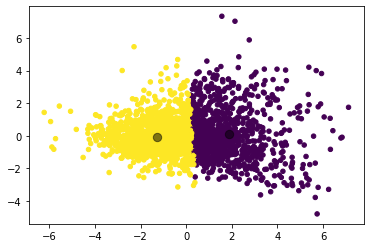

In [151]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
pca_customer_profile = search.best_estimator_['pca'].transform(scaled_customer_profile)
clusters_customers = search.predict(customer_profile) # scaling and pca are done in the pipeline
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = search.best_estimator_['clustering'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

What's the number of customers in each cluster?

In [152]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,1,0
CustomersNo,1343,938


## DBSCAN

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [154]:
# define a pipeline to search for the best combination of PCA truncation, scaler and the number of kmeans clusters
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA()), # a common practice before doing clustering: PCA which calculates the dimensions which best maximize variance; 
                           # it does dimensionality reduction while keeping the most important features, i.e. combinations of features best describe customers.
                           ('clustering', DBSCAN())])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'clustering__eps': (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4),
    'clustering__metric': ('euclidean', 'manhattan', 'cosine'),
    'clustering__min_samples': (5, 10)}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 252 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    6.6s finished


In [155]:
dbscan_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
dbscan_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__eps': 0.35, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.370431,1
"{'clustering__eps': 0.4, 'clustering__metric': 'euclidean', 'clustering__min_samples': 5, 'pca__n_components': 2}",0.311063,2
"{'clustering__eps': 0.4, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.263326,3
"{'clustering__eps': 0.25, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.101191,4
"{'clustering__eps': 0.4, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.097980,5
"{'clustering__eps': 0.3, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.078351,6
"{'clustering__eps': 0.3, 'clustering__metric': 'euclidean', 'clustering__min_samples': 5, 'pca__n_components': 2}",-0.004885,7
"{'clustering__eps': 0.35, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",-0.006702,8
"{'clustering__eps': 0.35, 'clustering__metric': 'euclidean', 'clustering__min_samples': 5, 'pca__n_components': 2}",-0.057460,9
"{'clustering__eps': 0.3, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",-0.079472,10


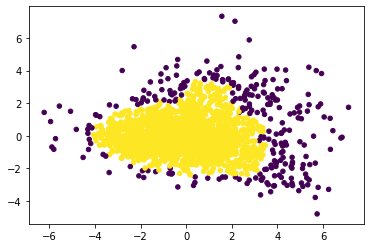

In [156]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
pca_customer_profile = search.best_estimator_['pca'].transform(scaled_customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(pca_customer_profile)
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [157]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,-1
CustomersNo,2019,262


## Agglomerative Clustering

In [144]:
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [145]:
# define a pipeline to search for the best combination of PCA truncation, scaler and the number of kmeans clusters
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           # ('pca', PCA()), # skipping PCA since the Feature Agglomeration uses agglomerative clustering to group together features 
                           # that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool.
                           ('clustering', AgglomerativeClustering())])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    # 'pca__n_components': range(2, n_features + 1),
    'clustering__n_clusters' : range(2, 10),
    'clustering__affinity': ('euclidean', 'manhattan', 'cosine'),
    'clustering__linkage': ('ward', 'complete', 'average', 'single')}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 96 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.5s finished


In [146]:
agglomerative_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
agglomerative_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__affinity': 'euclidean', 'clustering__linkage': 'single', 'clustering__n_clusters': 2}",0.568843,1
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'single', 'clustering__n_clusters': 2}",0.564757,2
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'average', 'clustering__n_clusters': 2}",0.544670,3
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'single', 'clustering__n_clusters': 3}",0.541419,4
"{'clustering__affinity': 'euclidean', 'clustering__linkage': 'single', 'clustering__n_clusters': 3}",0.541419,4
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'single', 'clustering__n_clusters': 4}",0.506850,6
"{'clustering__affinity': 'euclidean', 'clustering__linkage': 'average', 'clustering__n_clusters': 2}",0.465100,7
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'complete', 'clustering__n_clusters': 2}",0.408574,8
"{'clustering__affinity': 'manhattan', 'clustering__linkage': 'average', 'clustering__n_clusters': 3}",0.400844,9
"{'clustering__affinity': 'euclidean', 'clustering__linkage': 'complete', 'clustering__n_clusters': 2}",0.388391,10
